In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
def print_red(skk): print("\033[91m {}\033[00m" .format(skk))
def print_green(skk): print("\033[92m {}\033[00m" .format(skk))
def print_yellow(skk): print("\033[93m {}\033[00m" .format(skk))

In [3]:
def load_real_samples():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
    X = X_train.astype('float32')
    X = (X / 255)
    return X, y_train

In [4]:
X_train, y_train = load_real_samples()

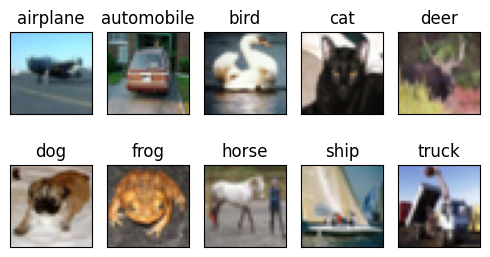

In [5]:
WIDTH_SIZE = 5
HEIGHT_SIZE = 3

num_classes = len(np.unique(y_train))
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(WIDTH_SIZE, HEIGHT_SIZE))
for i in range(num_classes):
    ax = plt.subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    img = features_idx[img_num,::]
    ax.set_title(class_names[i] )
    plt.imshow(img)

plt.tight_layout()

In [6]:

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')


X_train shape: (50000, 32, 32, 3)
50000 train samples


In [7]:
latent_dim = 100
input_shape = X_train[0].shape
print(input_shape)

(32, 32, 3)


In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
import numpy as np

class DCGAN():
    def __init__(self, input_shape, latent_dim):
        self.img_shape = input_shape
        self.latent_dim = latent_dim

        self.discriminator = self.build_discriminator()

        self.generator = self.build_generator()

        self.gan = self.define_gan()

    def build_generator(self):
        model = models.Sequential(name="Generator")

        n_nodes = 128 * 8 * 8

        model.add(layers.Dense(n_nodes, input_dim=self.latent_dim))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Reshape((8, 8, 128)))

        model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2DTranspose(32, (5,5), strides=(2,2), padding='same'))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2D(3, (5,5), activation='sigmoid', padding='same'))

        model.summary()

        return model

    def build_discriminator(self):
        model = models.Sequential(name="Discriminator")

        model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))
        model.add(layers.Dropout(0.25))

        model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
        model.add(layers.LeakyReLU(alpha=0.2))

        model.add(layers.Flatten())

        model.add(layers.Dense(1, activation='sigmoid'))

        model.summary()

        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        return model

    def define_gan(self):
        self.discriminator.trainable = False
        model = models.Sequential(name="GAN")

        model.add(self.generator)
        model.add(self.discriminator)

        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt)

        model.summary()

        return model

    def generate_real_samples(self, dataset, n_samples):
        # choose random images
        ix = np.random.randint(0, dataset.shape[0], n_samples)

        X = dataset[ix]

        y = np.ones((n_samples, 1)) ##Label=1 indicating they are real
        return X, y

    def generate_latent_points(self, latent_dim, n_samples):
        # generate points in the latent space
        x_input = np.random.randn(latent_dim * n_samples)

        x_input = x_input.reshape(n_samples, latent_dim)
        return x_input

    def generate_fake_samples(self, latent_dim, n_samples):

        x_input = self.generate_latent_points(latent_dim, n_samples)
        # predict using generator to generate fake samples.
        X = self.generator.predict(x_input, verbose=0)

        y = np.zeros((n_samples, 1))  #Label=0 indicating they are fake
        return X, y



    def train(self, X_train, epochs, batch_size=128, plot_interval=50):
        bat_per_epo = int(X_train.shape[0] / batch_size)
        half_batch = int(batch_size / 2)

        d_loss_real_list, d_loss_fake_list, g_loss_list = [], [], []

        metrics = ['d_loss_real', 'd_loss_fake', 'g_loss']

        save_path  =  "/content/drive/My Drive/dcgan_weights.h5"
        checkpoint_callback = ModelCheckpoint(filepath=save_path, save_weights_only=True, save_best_only=True)

        for epoch in range(epochs):
            print(f"\nEpoch: {epoch+1}/{epochs}")

            progbar = Progbar(bat_per_epo, stateful_metrics=metrics)

            for j in range(bat_per_epo):
#                 print_yellow(f"Step Num {j+1} of epoch {epoch+1}")

                # Train the discriminator on real and fake images, separately (half batch each)
                X_real, y_real = self.generate_real_samples(X_train, half_batch)
                d_loss_real, _ = self.discriminator.train_on_batch(X_real, y_real)

                X_fake, y_fake = self.generate_fake_samples(self.latent_dim, half_batch)
                d_loss_fake, _ = self.discriminator.train_on_batch(X_fake, y_fake)

                X_gan = self.generate_latent_points(self.latent_dim, batch_size)
                y_gan = np.ones((batch_size, 1))

                g_loss = self.gan.train_on_batch(X_gan, y_gan)

                d_loss_real_list.append(d_loss_real)
                d_loss_fake_list.append(d_loss_fake)
                g_loss_list.append(g_loss)

                # Update the existing progress bar with the latest loss values
                values = [('d_loss_real', d_loss_real), ('d_loss_fake', d_loss_fake), ('g_loss', g_loss)]
                progbar.add(1, values=values)

            if (epoch + 1) % plot_interval == 0:
                self.plot_generated_images(10)

            if save_path:
                self.gan.save_weights(save_path)

        return d_loss_real_list, d_loss_fake_list, g_loss_list

    def plot_generated_images(self, samples=10):
        z = np.random.normal(0, 1, (samples, self.latent_dim))
        x_fake = self.generator.predict(z)

        # Plot generated images
        plt.figure(figsize=(5, 3))
        for k in range(samples):
            plt.subplot(2, 5, k + 1)
            plt.imshow((0.5 * x_fake[k] + 0.5))
            plt.xticks([])
            plt.yticks([])
        plt.tight_layout()
        plt.show()


In [9]:
dcgan = DCGAN(input_shape, latent_dim)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         295168    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4, 256)       


Epoch: 1/200
195/195 [==============================] - 30s 152ms/step - d_loss_real: 0.5715 - d_loss_fake: 0.5150 - g_loss: 1.7097

Epoch: 2/200
195/195 [==============================] - 30s 154ms/step - d_loss_real: 0.6610 - d_loss_fake: 0.5655 - g_loss: 1.1061

Epoch: 3/200
195/195 [==============================] - 30s 154ms/step - d_loss_real: 0.5877 - d_loss_fake: 0.6722 - g_loss: 0.8808

Epoch: 4/200
195/195 [==============================] - 29s 148ms/step - d_loss_real: 0.7062 - d_loss_fake: 0.7198 - g_loss: 0.7364

Epoch: 5/200
1/1 [==============================] - 0s 172ms/step


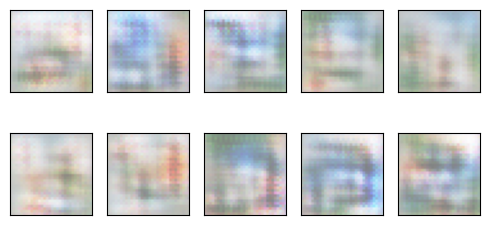


Epoch: 6/200
195/195 [==============================] - 30s 155ms/step - d_loss_real: 0.7210 - d_loss_fake: 0.6187 - g_loss: 0.8331

Epoch: 7/200
195/195 [==============================] - 30s 155ms/step - d_loss_real: 0.6236 - d_loss_fake: 0.6920 - g_loss: 0.7400

Epoch: 8/200
195/195 [==============================] - 29s 150ms/step - d_loss_real: 0.6358 - d_loss_fake: 0.7308 - g_loss: 0.7335

Epoch: 9/200
195/195 [==============================] - 30s 154ms/step - d_loss_real: 0.6750 - d_loss_fake: 0.6668 - g_loss: 0.7671

Epoch: 10/200
1/1 [==============================] - 0s 20ms/step


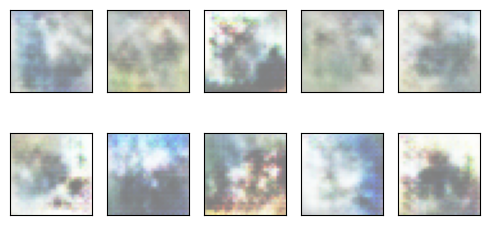


Epoch: 11/200
195/195 [==============================] - 31s 159ms/step - d_loss_real: 0.5689 - d_loss_fake: 0.6769 - g_loss: 0.7735

Epoch: 12/200
195/195 [==============================] - 30s 155ms/step - d_loss_real: 0.6240 - d_loss_fake: 0.7493 - g_loss: 0.6881

Epoch: 13/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.7044 - d_loss_fake: 0.6915 - g_loss: 0.7186

Epoch: 14/200
195/195 [==============================] - 31s 157ms/step - d_loss_real: 0.6842 - d_loss_fake: 0.7247 - g_loss: 0.6906

Epoch: 15/200
1/1 [==============================] - 0s 24ms/step


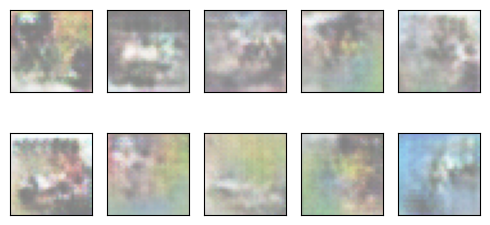


Epoch: 16/200
195/195 [==============================] - 31s 157ms/step - d_loss_real: 0.7118 - d_loss_fake: 0.6799 - g_loss: 0.7213

Epoch: 17/200
195/195 [==============================] - 30s 156ms/step - d_loss_real: 0.6831 - d_loss_fake: 0.7087 - g_loss: 0.7200

Epoch: 18/200
195/195 [==============================] - 30s 155ms/step - d_loss_real: 0.6656 - d_loss_fake: 0.7107 - g_loss: 0.7107

Epoch: 19/200
195/195 [==============================] - 30s 155ms/step - d_loss_real: 0.6817 - d_loss_fake: 0.6846 - g_loss: 0.7154

Epoch: 20/200
1/1 [==============================] - 0s 17ms/step


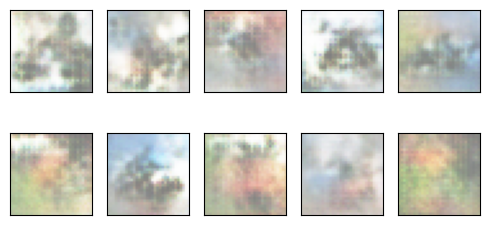


Epoch: 21/200
195/195 [==============================] - 32s 162ms/step - d_loss_real: 0.6734 - d_loss_fake: 0.7112 - g_loss: 0.7052

Epoch: 22/200
195/195 [==============================] - 31s 160ms/step - d_loss_real: 0.6773 - d_loss_fake: 0.7097 - g_loss: 0.7192

Epoch: 23/200
195/195 [==============================] - 30s 155ms/step - d_loss_real: 0.6978 - d_loss_fake: 0.7085 - g_loss: 0.7140

Epoch: 24/200
195/195 [==============================] - 31s 159ms/step - d_loss_real: 0.6455 - d_loss_fake: 0.7141 - g_loss: 0.7217

Epoch: 25/200
1/1 [==============================] - 0s 17ms/step


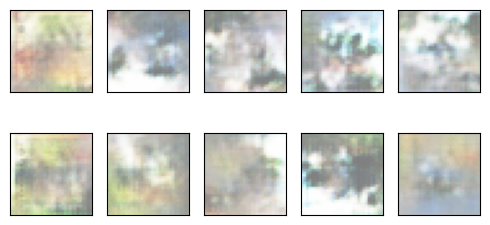


Epoch: 26/200
195/195 [==============================] - 33s 169ms/step - d_loss_real: 0.7099 - d_loss_fake: 0.6924 - g_loss: 0.7419

Epoch: 27/200
195/195 [==============================] - 31s 157ms/step - d_loss_real: 0.7080 - d_loss_fake: 0.6579 - g_loss: 0.7862

Epoch: 28/200
195/195 [==============================] - 31s 157ms/step - d_loss_real: 0.7253 - d_loss_fake: 0.6601 - g_loss: 0.7767

Epoch: 29/200
195/195 [==============================] - 30s 154ms/step - d_loss_real: 0.6922 - d_loss_fake: 0.6916 - g_loss: 0.7578

Epoch: 30/200
1/1 [==============================] - 0s 17ms/step


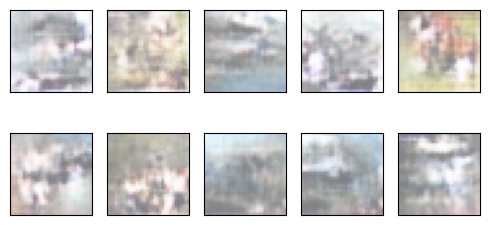


Epoch: 31/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.6789 - d_loss_fake: 0.6890 - g_loss: 0.7399

Epoch: 32/200
195/195 [==============================] - 31s 160ms/step - d_loss_real: 0.7200 - d_loss_fake: 0.6844 - g_loss: 0.7370

Epoch: 33/200
195/195 [==============================] - 31s 159ms/step - d_loss_real: 0.6968 - d_loss_fake: 0.6895 - g_loss: 0.7334

Epoch: 34/200
195/195 [==============================] - 31s 156ms/step - d_loss_real: 0.7004 - d_loss_fake: 0.6485 - g_loss: 0.7681

Epoch: 35/200
1/1 [==============================] - 0s 36ms/step


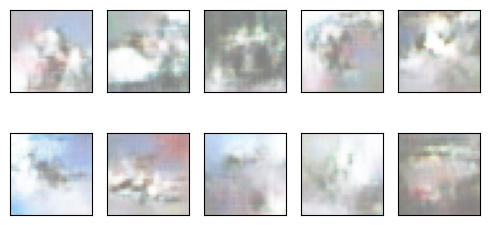


Epoch: 36/200
195/195 [==============================] - 32s 164ms/step - d_loss_real: 0.7140 - d_loss_fake: 0.6449 - g_loss: 0.7885

Epoch: 37/200
195/195 [==============================] - 32s 164ms/step - d_loss_real: 0.6789 - d_loss_fake: 0.6760 - g_loss: 0.7527

Epoch: 38/200
195/195 [==============================] - 31s 159ms/step - d_loss_real: 0.7061 - d_loss_fake: 0.6840 - g_loss: 0.7436

Epoch: 39/200
195/195 [==============================] - 31s 161ms/step - d_loss_real: 0.7107 - d_loss_fake: 0.6703 - g_loss: 0.7513

Epoch: 40/200
1/1 [==============================] - 0s 17ms/step


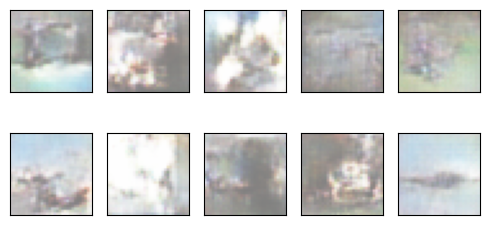


Epoch: 41/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.6935 - d_loss_fake: 0.6805 - g_loss: 0.7289

Epoch: 42/200
195/195 [==============================] - 31s 159ms/step - d_loss_real: 0.6867 - d_loss_fake: 0.7022 - g_loss: 0.7144

Epoch: 43/200
195/195 [==============================] - 32s 163ms/step - d_loss_real: 0.7001 - d_loss_fake: 0.6997 - g_loss: 0.7201

Epoch: 44/200
195/195 [==============================] - 30s 156ms/step - d_loss_real: 0.6948 - d_loss_fake: 0.6820 - g_loss: 0.7431

Epoch: 45/200
1/1 [==============================] - 0s 18ms/step


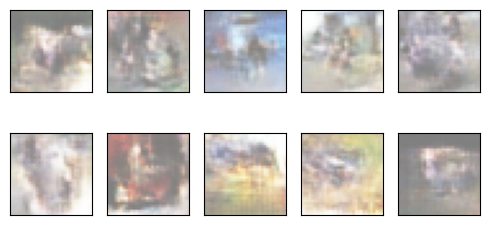


Epoch: 46/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.6974 - d_loss_fake: 0.6728 - g_loss: 0.7556

Epoch: 47/200
195/195 [==============================] - 32s 163ms/step - d_loss_real: 0.6822 - d_loss_fake: 0.7061 - g_loss: 0.7417

Epoch: 48/200
195/195 [==============================] - 32s 164ms/step - d_loss_real: 0.6988 - d_loss_fake: 0.6658 - g_loss: 0.7511

Epoch: 49/200
195/195 [==============================] - 31s 157ms/step - d_loss_real: 0.7058 - d_loss_fake: 0.6822 - g_loss: 0.7452

Epoch: 50/200
1/1 [==============================] - 0s 17ms/step


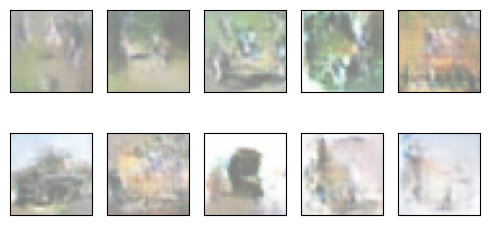


Epoch: 51/200
195/195 [==============================] - 33s 167ms/step - d_loss_real: 0.6795 - d_loss_fake: 0.6986 - g_loss: 0.7132

Epoch: 52/200
195/195 [==============================] - 33s 167ms/step - d_loss_real: 0.6588 - d_loss_fake: 0.7193 - g_loss: 0.7124

Epoch: 53/200
195/195 [==============================] - 31s 161ms/step - d_loss_real: 0.6783 - d_loss_fake: 0.7105 - g_loss: 0.7193

Epoch: 54/200
195/195 [==============================] - 31s 161ms/step - d_loss_real: 0.6782 - d_loss_fake: 0.6777 - g_loss: 0.7372

Epoch: 55/200
1/1 [==============================] - 0s 20ms/step


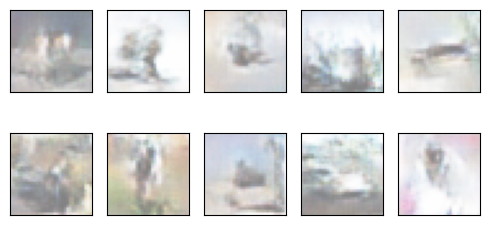


Epoch: 56/200
195/195 [==============================] - 34s 172ms/step - d_loss_real: 0.7065 - d_loss_fake: 0.6684 - g_loss: 0.7274

Epoch: 57/200
195/195 [==============================] - 33s 168ms/step - d_loss_real: 0.6914 - d_loss_fake: 0.6885 - g_loss: 0.7115

Epoch: 58/200
195/195 [==============================] - 32s 162ms/step - d_loss_real: 0.6985 - d_loss_fake: 0.7075 - g_loss: 0.7146

Epoch: 59/200
195/195 [==============================] - 32s 165ms/step - d_loss_real: 0.6972 - d_loss_fake: 0.6737 - g_loss: 0.7319

Epoch: 60/200
1/1 [==============================] - 0s 18ms/step


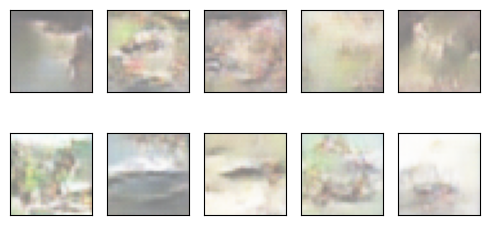


Epoch: 61/200
195/195 [==============================] - 35s 180ms/step - d_loss_real: 0.6896 - d_loss_fake: 0.6896 - g_loss: 0.7259

Epoch: 62/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.6884 - d_loss_fake: 0.6974 - g_loss: 0.7115

Epoch: 63/200
195/195 [==============================] - 32s 164ms/step - d_loss_real: 0.6913 - d_loss_fake: 0.6691 - g_loss: 0.7272

Epoch: 64/200
195/195 [==============================] - 33s 167ms/step - d_loss_real: 0.6941 - d_loss_fake: 0.6782 - g_loss: 0.7249

Epoch: 65/200
1/1 [==============================] - 0s 18ms/step


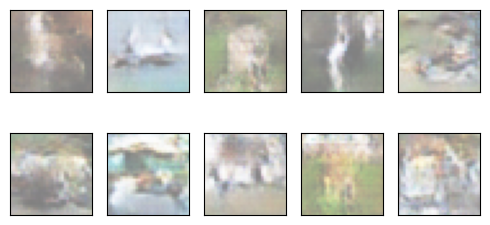


Epoch: 66/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.7001 - d_loss_fake: 0.6871 - g_loss: 0.7173

Epoch: 67/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.6939 - d_loss_fake: 0.6734 - g_loss: 0.7237

Epoch: 68/200
195/195 [==============================] - 33s 167ms/step - d_loss_real: 0.6890 - d_loss_fake: 0.6727 - g_loss: 0.7320

Epoch: 69/200
195/195 [==============================] - 32s 165ms/step - d_loss_real: 0.6788 - d_loss_fake: 0.6801 - g_loss: 0.7345

Epoch: 70/200
1/1 [==============================] - 0s 30ms/step


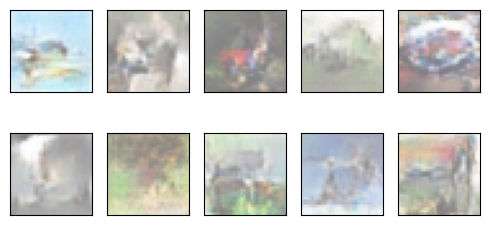


Epoch: 71/200
195/195 [==============================] - 34s 174ms/step - d_loss_real: 0.7008 - d_loss_fake: 0.6803 - g_loss: 0.7313

Epoch: 72/200
195/195 [==============================] - 35s 177ms/step - d_loss_real: 0.7061 - d_loss_fake: 0.6671 - g_loss: 0.7399

Epoch: 73/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.6816 - d_loss_fake: 0.7026 - g_loss: 0.7054

Epoch: 74/200
195/195 [==============================] - 32s 162ms/step - d_loss_real: 0.6856 - d_loss_fake: 0.6799 - g_loss: 0.7385

Epoch: 75/200
1/1 [==============================] - 0s 17ms/step


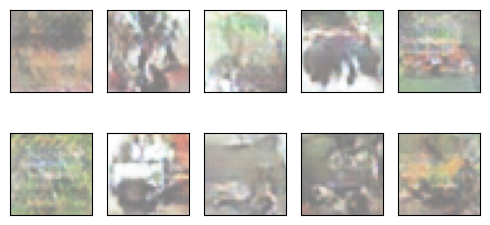


Epoch: 76/200
195/195 [==============================] - 35s 182ms/step - d_loss_real: 0.6863 - d_loss_fake: 0.7050 - g_loss: 0.7150

Epoch: 77/200
195/195 [==============================] - 34s 175ms/step - d_loss_real: 0.6984 - d_loss_fake: 0.6876 - g_loss: 0.7178

Epoch: 78/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.6988 - d_loss_fake: 0.6979 - g_loss: 0.7115

Epoch: 79/200
195/195 [==============================] - 33s 169ms/step - d_loss_real: 0.6933 - d_loss_fake: 0.6981 - g_loss: 0.7327

Epoch: 80/200
1/1 [==============================] - 0s 18ms/step


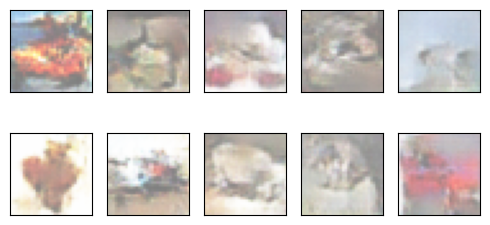


Epoch: 81/200
195/195 [==============================] - 35s 182ms/step - d_loss_real: 0.6955 - d_loss_fake: 0.6778 - g_loss: 0.7161

Epoch: 82/200
195/195 [==============================] - 35s 178ms/step - d_loss_real: 0.6959 - d_loss_fake: 0.6828 - g_loss: 0.7126

Epoch: 83/200
195/195 [==============================] - 32s 165ms/step - d_loss_real: 0.6968 - d_loss_fake: 0.6867 - g_loss: 0.7086

Epoch: 84/200
195/195 [==============================] - 33s 169ms/step - d_loss_real: 0.7012 - d_loss_fake: 0.6960 - g_loss: 0.7208

Epoch: 85/200
1/1 [==============================] - 0s 24ms/step


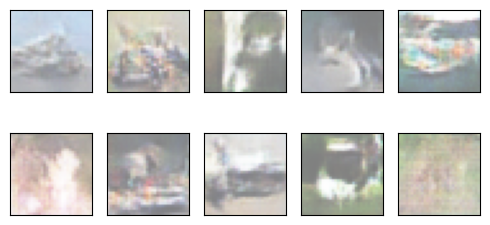


Epoch: 86/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.6910 - d_loss_fake: 0.6930 - g_loss: 0.7003

Epoch: 87/200
195/195 [==============================] - 34s 174ms/step - d_loss_real: 0.6988 - d_loss_fake: 0.6920 - g_loss: 0.7248

Epoch: 88/200
195/195 [==============================] - 33s 172ms/step - d_loss_real: 0.6920 - d_loss_fake: 0.6865 - g_loss: 0.7235

Epoch: 89/200
195/195 [==============================] - 32s 163ms/step - d_loss_real: 0.6779 - d_loss_fake: 0.7066 - g_loss: 0.6948

Epoch: 90/200
1/1 [==============================] - 0s 19ms/step


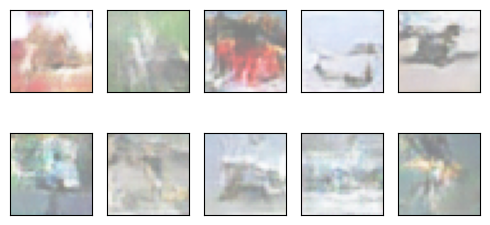


Epoch: 91/200
195/195 [==============================] - 36s 185ms/step - d_loss_real: 0.6987 - d_loss_fake: 0.6901 - g_loss: 0.7184

Epoch: 92/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.7009 - d_loss_fake: 0.6846 - g_loss: 0.7198

Epoch: 93/200
195/195 [==============================] - 33s 171ms/step - d_loss_real: 0.6813 - d_loss_fake: 0.6992 - g_loss: 0.7178

Epoch: 94/200
195/195 [==============================] - 33s 171ms/step - d_loss_real: 0.7043 - d_loss_fake: 0.6769 - g_loss: 0.7241

Epoch: 95/200
1/1 [==============================] - 0s 19ms/step


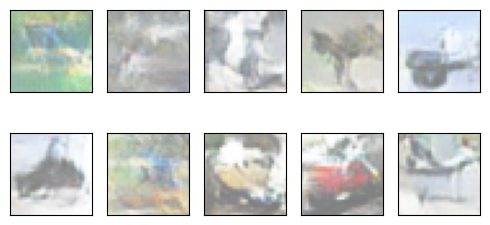


Epoch: 96/200
195/195 [==============================] - 36s 186ms/step - d_loss_real: 0.6942 - d_loss_fake: 0.6949 - g_loss: 0.7047

Epoch: 97/200
195/195 [==============================] - 35s 179ms/step - d_loss_real: 0.6724 - d_loss_fake: 0.7055 - g_loss: 0.7091

Epoch: 98/200
195/195 [==============================] - 34s 172ms/step - d_loss_real: 0.6820 - d_loss_fake: 0.6965 - g_loss: 0.7066

Epoch: 99/200
195/195 [==============================] - 32s 165ms/step - d_loss_real: 0.6945 - d_loss_fake: 0.6936 - g_loss: 0.7178

Epoch: 100/200
1/1 [==============================] - 0s 20ms/step


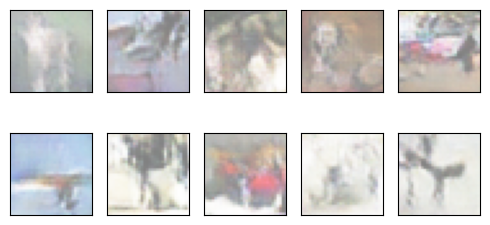


Epoch: 101/200
195/195 [==============================] - 36s 184ms/step - d_loss_real: 0.6814 - d_loss_fake: 0.6963 - g_loss: 0.7161

Epoch: 102/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.6957 - d_loss_fake: 0.6860 - g_loss: 0.7228

Epoch: 103/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.6857 - d_loss_fake: 0.6881 - g_loss: 0.7125

Epoch: 104/200
195/195 [==============================] - 32s 166ms/step - d_loss_real: 0.6816 - d_loss_fake: 0.7017 - g_loss: 0.7120

Epoch: 105/200
1/1 [==============================] - 0s 18ms/step


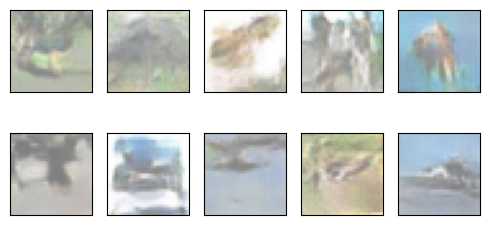


Epoch: 106/200
195/195 [==============================] - 36s 187ms/step - d_loss_real: 0.6863 - d_loss_fake: 0.6945 - g_loss: 0.7089

Epoch: 107/200
195/195 [==============================] - 36s 186ms/step - d_loss_real: 0.6904 - d_loss_fake: 0.6966 - g_loss: 0.7122

Epoch: 108/200
195/195 [==============================] - 33s 172ms/step - d_loss_real: 0.6873 - d_loss_fake: 0.6865 - g_loss: 0.7161

Epoch: 109/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.6890 - d_loss_fake: 0.6850 - g_loss: 0.7224

Epoch: 110/200
1/1 [==============================] - 0s 17ms/step


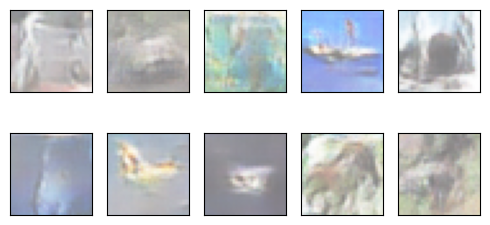


Epoch: 111/200
195/195 [==============================] - 36s 183ms/step - d_loss_real: 0.6961 - d_loss_fake: 0.6924 - g_loss: 0.7202

Epoch: 112/200
195/195 [==============================] - 35s 177ms/step - d_loss_real: 0.6939 - d_loss_fake: 0.6885 - g_loss: 0.7162

Epoch: 113/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.6871 - d_loss_fake: 0.6983 - g_loss: 0.7217

Epoch: 114/200
195/195 [==============================] - 33s 169ms/step - d_loss_real: 0.6982 - d_loss_fake: 0.6849 - g_loss: 0.7090

Epoch: 115/200
1/1 [==============================] - 0s 16ms/step


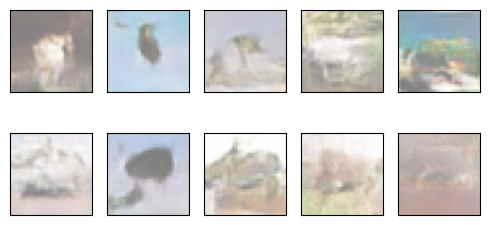


Epoch: 116/200
195/195 [==============================] - 36s 185ms/step - d_loss_real: 0.7127 - d_loss_fake: 0.6721 - g_loss: 0.7226

Epoch: 117/200
195/195 [==============================] - 36s 183ms/step - d_loss_real: 0.7013 - d_loss_fake: 0.6693 - g_loss: 0.7317

Epoch: 118/200
195/195 [==============================] - 33s 171ms/step - d_loss_real: 0.7002 - d_loss_fake: 0.6887 - g_loss: 0.7061

Epoch: 119/200
195/195 [==============================] - 33s 167ms/step - d_loss_real: 0.6989 - d_loss_fake: 0.6814 - g_loss: 0.7174

Epoch: 120/200
1/1 [==============================] - 0s 20ms/step


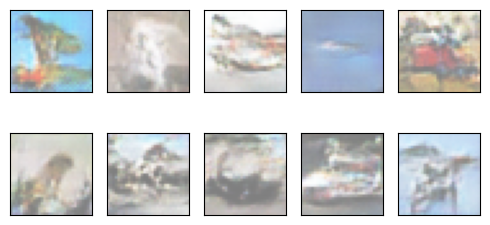


Epoch: 121/200
195/195 [==============================] - 37s 190ms/step - d_loss_real: 0.6808 - d_loss_fake: 0.7121 - g_loss: 0.7018

Epoch: 122/200
195/195 [==============================] - 36s 183ms/step - d_loss_real: 0.6835 - d_loss_fake: 0.6830 - g_loss: 0.7204

Epoch: 123/200
195/195 [==============================] - 34s 175ms/step - d_loss_real: 0.6851 - d_loss_fake: 0.7111 - g_loss: 0.7085

Epoch: 124/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.6874 - d_loss_fake: 0.6848 - g_loss: 0.7079

Epoch: 125/200
1/1 [==============================] - 0s 28ms/step


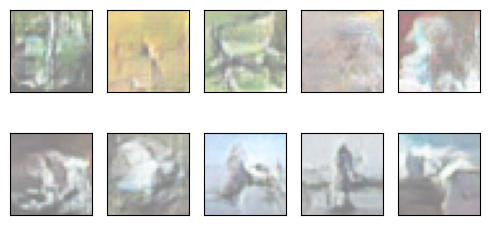


Epoch: 126/200
195/195 [==============================] - 37s 185ms/step - d_loss_real: 0.7040 - d_loss_fake: 0.6831 - g_loss: 0.7159

Epoch: 127/200
195/195 [==============================] - 36s 183ms/step - d_loss_real: 0.6918 - d_loss_fake: 0.6750 - g_loss: 0.7371

Epoch: 128/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.7068 - d_loss_fake: 0.6947 - g_loss: 0.7084

Epoch: 129/200
195/195 [==============================] - 34s 173ms/step - d_loss_real: 0.7048 - d_loss_fake: 0.6837 - g_loss: 0.7146

Epoch: 130/200
1/1 [==============================] - 0s 18ms/step


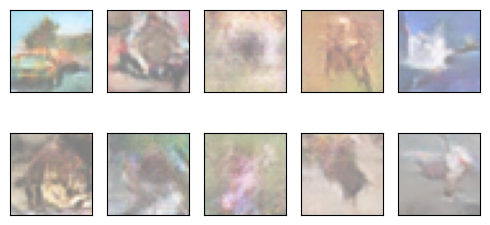


Epoch: 131/200
195/195 [==============================] - 37s 189ms/step - d_loss_real: 0.6958 - d_loss_fake: 0.6857 - g_loss: 0.7178

Epoch: 132/200
195/195 [==============================] - 36s 187ms/step - d_loss_real: 0.6956 - d_loss_fake: 0.6807 - g_loss: 0.7191

Epoch: 133/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.6870 - d_loss_fake: 0.6839 - g_loss: 0.7433

Epoch: 134/200
195/195 [==============================] - 33s 170ms/step - d_loss_real: 0.7001 - d_loss_fake: 0.6760 - g_loss: 0.7186

Epoch: 135/200
1/1 [==============================] - 0s 17ms/step


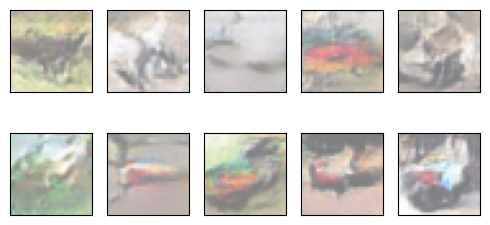


Epoch: 136/200
195/195 [==============================] - 36s 187ms/step - d_loss_real: 0.6909 - d_loss_fake: 0.6898 - g_loss: 0.7125

Epoch: 137/200
195/195 [==============================] - 36s 186ms/step - d_loss_real: 0.6867 - d_loss_fake: 0.6918 - g_loss: 0.7122

Epoch: 138/200
195/195 [==============================] - 34s 174ms/step - d_loss_real: 0.7029 - d_loss_fake: 0.6856 - g_loss: 0.7178

Epoch: 139/200
195/195 [==============================] - 34s 175ms/step - d_loss_real: 0.7077 - d_loss_fake: 0.6717 - g_loss: 0.7262

Epoch: 140/200
1/1 [==============================] - 0s 25ms/step


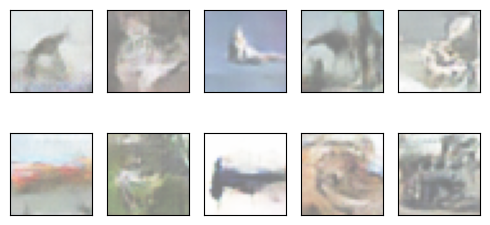


Epoch: 141/200
195/195 [==============================] - 36s 186ms/step - d_loss_real: 0.6860 - d_loss_fake: 0.6835 - g_loss: 0.7192

Epoch: 142/200
195/195 [==============================] - 36s 182ms/step - d_loss_real: 0.6915 - d_loss_fake: 0.6923 - g_loss: 0.7150

Epoch: 143/200
195/195 [==============================] - 35s 178ms/step - d_loss_real: 0.6911 - d_loss_fake: 0.6785 - g_loss: 0.7154

Epoch: 144/200
195/195 [==============================] - 35s 182ms/step - d_loss_real: 0.6842 - d_loss_fake: 0.6963 - g_loss: 0.7059

Epoch: 145/200
1/1 [==============================] - 0s 17ms/step


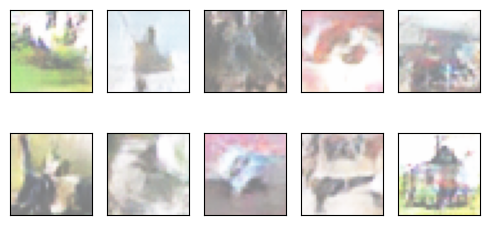


Epoch: 146/200
195/195 [==============================] - 38s 195ms/step - d_loss_real: 0.6775 - d_loss_fake: 0.6888 - g_loss: 0.7192

Epoch: 147/200
195/195 [==============================] - 37s 190ms/step - d_loss_real: 0.6804 - d_loss_fake: 0.6970 - g_loss: 0.7012

Epoch: 148/200
195/195 [==============================] - 35s 182ms/step - d_loss_real: 0.6925 - d_loss_fake: 0.6730 - g_loss: 0.7233

Epoch: 149/200
195/195 [==============================] - 35s 179ms/step - d_loss_real: 0.6871 - d_loss_fake: 0.6856 - g_loss: 0.7132

Epoch: 150/200
1/1 [==============================] - 0s 20ms/step


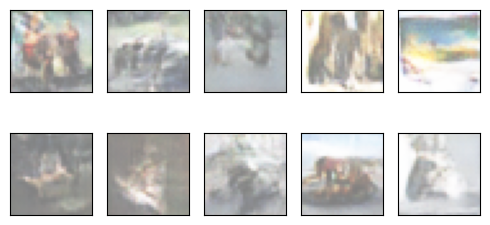


Epoch: 151/200
195/195 [==============================] - 38s 194ms/step - d_loss_real: 0.6937 - d_loss_fake: 0.6818 - g_loss: 0.7158

Epoch: 152/200
195/195 [==============================] - 37s 189ms/step - d_loss_real: 0.6963 - d_loss_fake: 0.6907 - g_loss: 0.7163

Epoch: 153/200
195/195 [==============================] - 36s 183ms/step - d_loss_real: 0.7022 - d_loss_fake: 0.6781 - g_loss: 0.7345

Epoch: 154/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.6960 - d_loss_fake: 0.6950 - g_loss: 0.7093

Epoch: 155/200
1/1 [==============================] - 0s 18ms/step


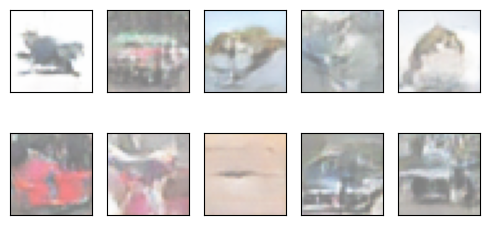


Epoch: 156/200
195/195 [==============================] - 38s 196ms/step - d_loss_real: 0.6991 - d_loss_fake: 0.6898 - g_loss: 0.7218

Epoch: 157/200
195/195 [==============================] - 37s 192ms/step - d_loss_real: 0.6886 - d_loss_fake: 0.6857 - g_loss: 0.7176

Epoch: 158/200
195/195 [==============================] - 36s 182ms/step - d_loss_real: 0.6995 - d_loss_fake: 0.6873 - g_loss: 0.7098

Epoch: 159/200
195/195 [==============================] - 34s 177ms/step - d_loss_real: 0.6864 - d_loss_fake: 0.6844 - g_loss: 0.7265

Epoch: 160/200
1/1 [==============================] - 0s 18ms/step


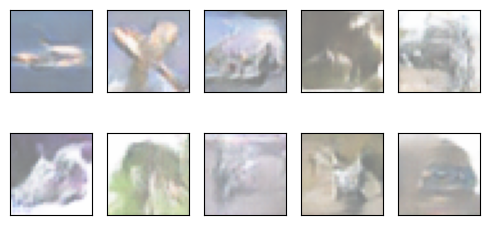


Epoch: 161/200
195/195 [==============================] - 38s 195ms/step - d_loss_real: 0.6906 - d_loss_fake: 0.6867 - g_loss: 0.7154

Epoch: 162/200
195/195 [==============================] - 37s 189ms/step - d_loss_real: 0.6775 - d_loss_fake: 0.6899 - g_loss: 0.7226

Epoch: 163/200
195/195 [==============================] - 36s 183ms/step - d_loss_real: 0.6991 - d_loss_fake: 0.6850 - g_loss: 0.7164

Epoch: 164/200
195/195 [==============================] - 34s 175ms/step - d_loss_real: 0.6991 - d_loss_fake: 0.6859 - g_loss: 0.7206

Epoch: 165/200
1/1 [==============================] - 0s 19ms/step


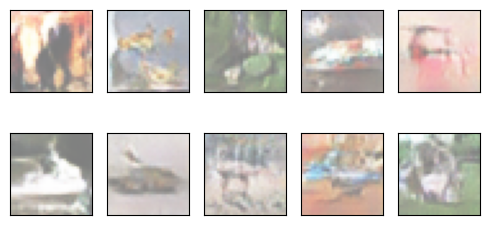


Epoch: 166/200
195/195 [==============================] - 38s 197ms/step - d_loss_real: 0.7029 - d_loss_fake: 0.6816 - g_loss: 0.7333

Epoch: 167/200
195/195 [==============================] - 38s 197ms/step - d_loss_real: 0.6879 - d_loss_fake: 0.6815 - g_loss: 0.7208

Epoch: 168/200
195/195 [==============================] - 36s 186ms/step - d_loss_real: 0.6895 - d_loss_fake: 0.6841 - g_loss: 0.7168

Epoch: 169/200
195/195 [==============================] - 34s 176ms/step - d_loss_real: 0.6954 - d_loss_fake: 0.6952 - g_loss: 0.7163

Epoch: 170/200
1/1 [==============================] - 0s 19ms/step


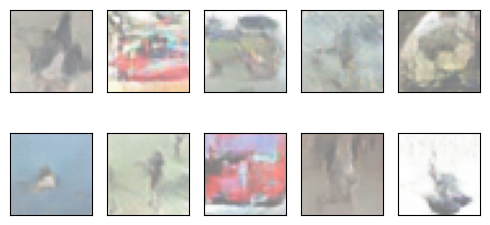


Epoch: 171/200
195/195 [==============================] - 39s 198ms/step - d_loss_real: 0.6833 - d_loss_fake: 0.6917 - g_loss: 0.7180

Epoch: 172/200
195/195 [==============================] - 37s 190ms/step - d_loss_real: 0.6891 - d_loss_fake: 0.6841 - g_loss: 0.7418

Epoch: 173/200
195/195 [==============================] - 36s 184ms/step - d_loss_real: 0.6980 - d_loss_fake: 0.6967 - g_loss: 0.7209

Epoch: 174/200
195/195 [==============================] - 35s 180ms/step - d_loss_real: 0.6874 - d_loss_fake: 0.6928 - g_loss: 0.7150

Epoch: 175/200
1/1 [==============================] - 0s 24ms/step


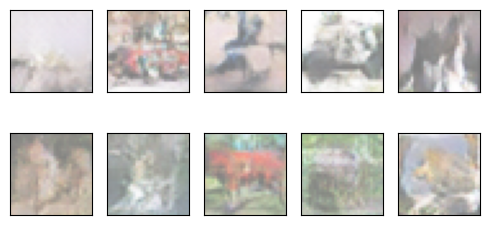


Epoch: 176/200
195/195 [==============================] - 39s 200ms/step - d_loss_real: 0.6949 - d_loss_fake: 0.6879 - g_loss: 0.7118

Epoch: 177/200
195/195 [==============================] - 37s 189ms/step - d_loss_real: 0.7014 - d_loss_fake: 0.6884 - g_loss: 0.7185

Epoch: 178/200
195/195 [==============================] - 35s 180ms/step - d_loss_real: 0.6957 - d_loss_fake: 0.6927 - g_loss: 0.7240

Epoch: 179/200
195/195 [==============================] - 35s 180ms/step - d_loss_real: 0.6756 - d_loss_fake: 0.6934 - g_loss: 0.7164

Epoch: 180/200
187/195 [===========================>..] - ETA: 1s - d_loss_real: 0.6971 - d_loss_fake: 0.6636 - g_loss: 0.7373

In [ ]:
d_loss_real_list, d_loss_fake_list, g_loss_list =  dcgan.train(X_train, epochs=200, batch_size=256, plot_interval=5)